## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.



---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [ ]:
# load the data if you need to; if you have already loaded the data, you may comment this cell out
# -- DO NOT CHANGE THIS CELL -- #
!mkdir /data
!wget -P /data/ https://s3.amazonaws.com/video.udacity-data.com/topher/2018/May/5aea1b91_train-test-data/train-test-data.zip
!unzip -n /data/train-test-data.zip -d /data

<div class="alert alert-info">**Note:** Workspaces automatically close connections after 30 minutes of inactivity (including inactivity while training!). Use the code snippet below to keep your workspace alive during training. (The active_session context manager is imported below.)
</div>
```
from workspace_utils import active_session

with active_session():
    train_model(num_epochs)
```


In [16]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
## Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout(p=0.1)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop2): Dropout(p=0.2)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (drop3): Dropout(p=0.3)
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (drop4): Dropout(p=0.4)
  (fc1): Linear(in_features=36864, out_features=1000, bias=True)
  (drop5): Dropout(p=0.5)
  (fc2): Linear(in_features=1000, out_features=1000, bias=True)
  (drop6): Dropout(p=0.6)
  (fc3): Linear(in_features=1000, out_features=136, bias=True)
)


## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [46]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [47]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/data/training_frames_keypoints.csv',
                                             root_dir='/data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains. Too large a batch size may cause your model to crash and/or run out of memory while training.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [48]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [49]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/data/test_frames_keypoints.csv',
                                             root_dir='/data/test/',
                                             transform=data_transform)



In [50]:
# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Wrap the image in a Variable, so that the net can process it as input and track how it changes as the image moves through the network.
3. Make sure the image is a FloatTensor, which the model expects.
4. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [51]:
# test the model on a batch of test images

def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [52]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [53]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')

#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

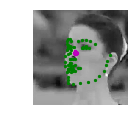

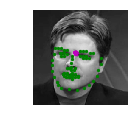

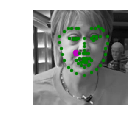

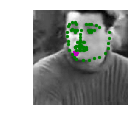

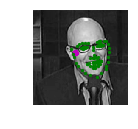

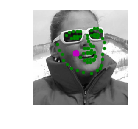

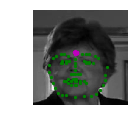

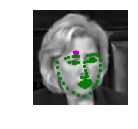

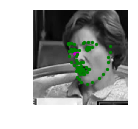

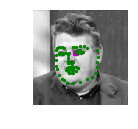

In [54]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [55]:
## Define the loss and optimization
import torch.optim as optim
import torch.nn.init as I

def init_weights(m):
    if type(m) == nn.Conv2d:
        I.uniform_(m.weight)
    elif type(m) == nn.Linear:
        I.xavier_uniform_(m.weight)


#net.apply(init_weights)

#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [56]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [58]:
# train your network
n_epochs = 10 # start small, and increase when you've decided on your model structure and hyperparams

# this is a Workspaces-specific context manager to keep the connection
# alive while training your model, not part of pytorch
with active_session():
    train_net(n_epochs)

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 1, Batch: 10, Avg. Loss: 0.09638622514903546
Epoch: 1, Batch: 20, Avg. Loss: 0.09960434734821319
Epoch: 1, Batch: 30, Avg. Loss: 0.07778569310903549
Epoch: 1, Batch: 40, Avg. Loss: 0.07253711223602295
Epoch: 1, Batch: 50, Avg. Loss: 0.08914566785097122
Epoch: 1, Batch: 60, Avg. Loss: 0.07461303398013115
Epoch: 1, Batch: 70, Avg. Loss: 0.10198682844638825
Epoch: 1, Batch: 80, Avg. Loss: 0.08169290870428085
Epoch: 1, Batch: 90, Avg. Loss: 0.07793200090527534
Epoch: 1, Batch: 100, Avg. Loss: 0.08146190457046032
Epoch: 1, Batch: 110, Avg. Loss: 0.08769654668867588
Epoch: 1, Batch: 120, Avg. Loss: 0.08711253926157951
Epoch: 1, Batch: 130, Avg. Loss: 0.11130599826574325
Epoch: 1, Batch: 140, Avg. Loss: 0.09508430026471615
Epoch: 1, Batch: 150, Avg. Loss: 0.11016731671988964
Epoch: 1, Batch: 160, Avg. Loss: 0.0853171780705452
Epoch: 1, Batch: 170, Avg. Loss: 0.08020345196127891
Epoch: 1, Batch: 180, Avg. Loss: 0.08037544973194599
Epoch: 1, Batch: 190, Avg. Loss: 0.0868985753506422
Epoc

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 2, Batch: 10, Avg. Loss: 0.07099000662565232
Epoch: 2, Batch: 20, Avg. Loss: 0.08805739358067513
Epoch: 2, Batch: 30, Avg. Loss: 0.06715533249080181
Epoch: 2, Batch: 40, Avg. Loss: 0.07626128606498242
Epoch: 2, Batch: 50, Avg. Loss: 0.08066795282065868
Epoch: 2, Batch: 60, Avg. Loss: 0.08831013403832913
Epoch: 2, Batch: 70, Avg. Loss: 0.07434396408498287
Epoch: 2, Batch: 80, Avg. Loss: 0.08492005206644535
Epoch: 2, Batch: 90, Avg. Loss: 0.07666291818022727
Epoch: 2, Batch: 100, Avg. Loss: 0.06977148670703173
Epoch: 2, Batch: 110, Avg. Loss: 0.085281153768301
Epoch: 2, Batch: 120, Avg. Loss: 0.07340097613632679
Epoch: 2, Batch: 130, Avg. Loss: 0.0782686322927475
Epoch: 2, Batch: 140, Avg. Loss: 0.08065016940236092
Epoch: 2, Batch: 150, Avg. Loss: 0.07853297106921672
Epoch: 2, Batch: 160, Avg. Loss: 0.08097499758005142
Epoch: 2, Batch: 170, Avg. Loss: 0.07058607339859009
Epoch: 2, Batch: 180, Avg. Loss: 0.06802711486816407
Epoch: 2, Batch: 190, Avg. Loss: 0.06986370049417019
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 3, Batch: 10, Avg. Loss: 0.08101463504135609
Epoch: 3, Batch: 20, Avg. Loss: 0.08432613834738731
Epoch: 3, Batch: 30, Avg. Loss: 0.09497785121202469
Epoch: 3, Batch: 40, Avg. Loss: 0.0695868406444788
Epoch: 3, Batch: 50, Avg. Loss: 0.08850039280951023
Epoch: 3, Batch: 60, Avg. Loss: 0.06601422019302845
Epoch: 3, Batch: 70, Avg. Loss: 0.07928446680307388
Epoch: 3, Batch: 80, Avg. Loss: 0.0675817582756281
Epoch: 3, Batch: 90, Avg. Loss: 0.06318458523601293
Epoch: 3, Batch: 100, Avg. Loss: 0.06212625615298748
Epoch: 3, Batch: 110, Avg. Loss: 0.07187929414212704
Epoch: 3, Batch: 120, Avg. Loss: 0.0759536311030388
Epoch: 3, Batch: 130, Avg. Loss: 0.052690863609313965
Epoch: 3, Batch: 140, Avg. Loss: 0.0740570992231369
Epoch: 3, Batch: 150, Avg. Loss: 0.07830350883305073
Epoch: 3, Batch: 160, Avg. Loss: 0.06880382802337408
Epoch: 3, Batch: 170, Avg. Loss: 0.06393571384251118
Epoch: 3, Batch: 180, Avg. Loss: 0.05465965494513512
Epoch: 3, Batch: 190, Avg. Loss: 0.06691804528236389
Epoch

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 4, Batch: 10, Avg. Loss: 0.06273704748600721
Epoch: 4, Batch: 20, Avg. Loss: 0.06677655819803477
Epoch: 4, Batch: 30, Avg. Loss: 0.055608445033431056
Epoch: 4, Batch: 40, Avg. Loss: 0.04522805027663708
Epoch: 4, Batch: 50, Avg. Loss: 0.04459329545497894
Epoch: 4, Batch: 60, Avg. Loss: 0.05369719136506319
Epoch: 4, Batch: 70, Avg. Loss: 0.05610205810517073
Epoch: 4, Batch: 80, Avg. Loss: 0.036273885145783426
Epoch: 4, Batch: 90, Avg. Loss: 0.04039969481527805
Epoch: 4, Batch: 100, Avg. Loss: 0.04569273293018341
Epoch: 4, Batch: 110, Avg. Loss: 0.049620818719267844
Epoch: 4, Batch: 120, Avg. Loss: 0.046887682378292085
Epoch: 4, Batch: 130, Avg. Loss: 0.051751256361603735
Epoch: 4, Batch: 140, Avg. Loss: 0.048855329677462575
Epoch: 4, Batch: 150, Avg. Loss: 0.04971158038824797
Epoch: 4, Batch: 160, Avg. Loss: 0.040566444583237174
Epoch: 4, Batch: 170, Avg. Loss: 0.05909043848514557
Epoch: 4, Batch: 180, Avg. Loss: 0.05082649514079094
Epoch: 4, Batch: 190, Avg. Loss: 0.0477678006514

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 5, Batch: 10, Avg. Loss: 0.02864811271429062
Epoch: 5, Batch: 20, Avg. Loss: 0.04943951927125454
Epoch: 5, Batch: 30, Avg. Loss: 0.03779659792780876
Epoch: 5, Batch: 40, Avg. Loss: 0.035143515467643736
Epoch: 5, Batch: 50, Avg. Loss: 0.0340056411921978
Epoch: 5, Batch: 60, Avg. Loss: 0.042237683571875094
Epoch: 5, Batch: 70, Avg. Loss: 0.04900783747434616
Epoch: 5, Batch: 80, Avg. Loss: 0.047735697403550145
Epoch: 5, Batch: 90, Avg. Loss: 0.04090093355625868
Epoch: 5, Batch: 100, Avg. Loss: 0.04305650778114796
Epoch: 5, Batch: 110, Avg. Loss: 0.05584695730358362
Epoch: 5, Batch: 120, Avg. Loss: 0.031120885536074637
Epoch: 5, Batch: 130, Avg. Loss: 0.03438501507043838
Epoch: 5, Batch: 140, Avg. Loss: 0.032415121980011466
Epoch: 5, Batch: 150, Avg. Loss: 0.03373084468767047
Epoch: 5, Batch: 160, Avg. Loss: 0.03241306599229574
Epoch: 5, Batch: 170, Avg. Loss: 0.05561204869300127
Epoch: 5, Batch: 180, Avg. Loss: 0.04085413124412298
Epoch: 5, Batch: 190, Avg. Loss: 0.0344519792124629

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 6, Batch: 10, Avg. Loss: 0.03498050458729267
Epoch: 6, Batch: 20, Avg. Loss: 0.04464654382318258
Epoch: 6, Batch: 30, Avg. Loss: 0.05729965325444937
Epoch: 6, Batch: 40, Avg. Loss: 0.03696651663631201
Epoch: 6, Batch: 50, Avg. Loss: 0.02891917433589697
Epoch: 6, Batch: 60, Avg. Loss: 0.0343807915225625
Epoch: 6, Batch: 70, Avg. Loss: 0.06437381990253925
Epoch: 6, Batch: 80, Avg. Loss: 0.05013953037559986
Epoch: 6, Batch: 90, Avg. Loss: 0.04491103868931532
Epoch: 6, Batch: 100, Avg. Loss: 0.02913843709975481
Epoch: 6, Batch: 110, Avg. Loss: 0.03632861413061619
Epoch: 6, Batch: 120, Avg. Loss: 0.03418704755604267
Epoch: 6, Batch: 130, Avg. Loss: 0.036415938101708886
Epoch: 6, Batch: 140, Avg. Loss: 0.03712544906884432
Epoch: 6, Batch: 150, Avg. Loss: 0.04156236741691828
Epoch: 6, Batch: 160, Avg. Loss: 0.03852560464292765
Epoch: 6, Batch: 170, Avg. Loss: 0.042643189430236816
Epoch: 6, Batch: 180, Avg. Loss: 0.03851540153846145
Epoch: 6, Batch: 190, Avg. Loss: 0.024934968911111355


/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 7, Batch: 10, Avg. Loss: 0.035330382734537126
Epoch: 7, Batch: 20, Avg. Loss: 0.04145759642124176
Epoch: 7, Batch: 30, Avg. Loss: 0.030937796086072923
Epoch: 7, Batch: 40, Avg. Loss: 0.025285872258245946
Epoch: 7, Batch: 50, Avg. Loss: 0.03556042779237032
Epoch: 7, Batch: 60, Avg. Loss: 0.03038157019764185
Epoch: 7, Batch: 70, Avg. Loss: 0.02869491558521986
Epoch: 7, Batch: 80, Avg. Loss: 0.04465027097612619
Epoch: 7, Batch: 90, Avg. Loss: 0.04135593175888062
Epoch: 7, Batch: 100, Avg. Loss: 0.03417340340092778
Epoch: 7, Batch: 110, Avg. Loss: 0.056142034754157064
Epoch: 7, Batch: 120, Avg. Loss: 0.04929425530135632
Epoch: 7, Batch: 130, Avg. Loss: 0.03292698226869106
Epoch: 7, Batch: 140, Avg. Loss: 0.03500060029327869
Epoch: 7, Batch: 150, Avg. Loss: 0.0248209111392498
Epoch: 7, Batch: 160, Avg. Loss: 0.027637550607323647
Epoch: 7, Batch: 170, Avg. Loss: 0.027063434198498725
Epoch: 7, Batch: 180, Avg. Loss: 0.03812050372362137
Epoch: 7, Batch: 190, Avg. Loss: 0.031135395914316

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 8, Batch: 10, Avg. Loss: 0.03409430272877216
Epoch: 8, Batch: 20, Avg. Loss: 0.03667022008448839
Epoch: 8, Batch: 30, Avg. Loss: 0.0318246366456151
Epoch: 8, Batch: 40, Avg. Loss: 0.043823381513357164
Epoch: 8, Batch: 50, Avg. Loss: 0.03051713705062866
Epoch: 8, Batch: 60, Avg. Loss: 0.034268304146826266
Epoch: 8, Batch: 70, Avg. Loss: 0.03881821036338806
Epoch: 8, Batch: 80, Avg. Loss: 0.05058728428557515
Epoch: 8, Batch: 90, Avg. Loss: 0.028068494517356157
Epoch: 8, Batch: 100, Avg. Loss: 0.04071647152304649
Epoch: 8, Batch: 110, Avg. Loss: 0.03177323564887047
Epoch: 8, Batch: 120, Avg. Loss: 0.03044147752225399
Epoch: 8, Batch: 130, Avg. Loss: 0.032241012901067734
Epoch: 8, Batch: 140, Avg. Loss: 0.02942928271368146
Epoch: 8, Batch: 150, Avg. Loss: 0.029389565996825694
Epoch: 8, Batch: 160, Avg. Loss: 0.03476766441017389
Epoch: 8, Batch: 170, Avg. Loss: 0.025395586900413037
Epoch: 8, Batch: 180, Avg. Loss: 0.042415644600987436
Epoch: 8, Batch: 190, Avg. Loss: 0.02431690106168

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 9, Batch: 10, Avg. Loss: 0.03466816209256649
Epoch: 9, Batch: 20, Avg. Loss: 0.035072798281908034
Epoch: 9, Batch: 30, Avg. Loss: 0.034984500240534545
Epoch: 9, Batch: 40, Avg. Loss: 0.030736132990568876
Epoch: 9, Batch: 50, Avg. Loss: 0.02802017591893673
Epoch: 9, Batch: 60, Avg. Loss: 0.026839423459023237
Epoch: 9, Batch: 70, Avg. Loss: 0.027237632777541876
Epoch: 9, Batch: 80, Avg. Loss: 0.027207136433571578
Epoch: 9, Batch: 90, Avg. Loss: 0.030163584370166065
Epoch: 9, Batch: 100, Avg. Loss: 0.03310944540426135
Epoch: 9, Batch: 110, Avg. Loss: 0.05809316271916032
Epoch: 9, Batch: 120, Avg. Loss: 0.030625873524695636
Epoch: 9, Batch: 130, Avg. Loss: 0.033337545581161976
Epoch: 9, Batch: 140, Avg. Loss: 0.03938257284462452
Epoch: 9, Batch: 150, Avg. Loss: 0.03569067604839802
Epoch: 9, Batch: 160, Avg. Loss: 0.042959104664623736
Epoch: 9, Batch: 170, Avg. Loss: 0.033073567971587184
Epoch: 9, Batch: 180, Avg. Loss: 0.0497997360303998
Epoch: 9, Batch: 190, Avg. Loss: 0.0359668670

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Epoch: 10, Batch: 10, Avg. Loss: 0.04950735215097666
Epoch: 10, Batch: 20, Avg. Loss: 0.027148117870092393
Epoch: 10, Batch: 30, Avg. Loss: 0.02475400697439909
Epoch: 10, Batch: 40, Avg. Loss: 0.021809942461550234
Epoch: 10, Batch: 50, Avg. Loss: 0.01903868084773421
Epoch: 10, Batch: 60, Avg. Loss: 0.02884871866554022
Epoch: 10, Batch: 70, Avg. Loss: 0.0405253223143518
Epoch: 10, Batch: 80, Avg. Loss: 0.025233349204063414
Epoch: 10, Batch: 90, Avg. Loss: 0.03860634863376618
Epoch: 10, Batch: 100, Avg. Loss: 0.026691577024757863
Epoch: 10, Batch: 110, Avg. Loss: 0.02487272834405303
Epoch: 10, Batch: 120, Avg. Loss: 0.028577723540365696
Epoch: 10, Batch: 130, Avg. Loss: 0.046058145724236964
Epoch: 10, Batch: 140, Avg. Loss: 0.029363741539418696
Epoch: 10, Batch: 150, Avg. Loss: 0.021454238053411245
Epoch: 10, Batch: 160, Avg. Loss: 0.03722334057092667
Epoch: 10, Batch: 170, Avg. Loss: 0.028656320832669734
Epoch: 10, Batch: 180, Avg. Loss: 0.027249930985271932
Epoch: 10, Batch: 190, Avg. 

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [ ]:
#Load the saved model
model_dir = 'saved_models/'
model_name = 'keypoints_model_NaimishNet.pt'

net.load_state_dict(torch.load(model_dir+model_name))
net.eval()


In [59]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([10, 1, 224, 224])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


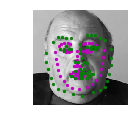

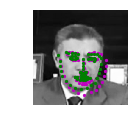

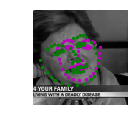

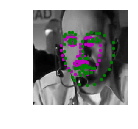

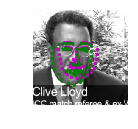

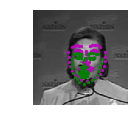

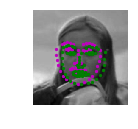

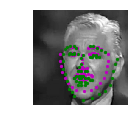

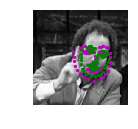

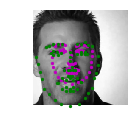

In [60]:
#visualize test output

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

Save your models but please **delete any checkpoints and saved models before you submit your project** otherwise your workspace may be too large to submit.

In [61]:

model_dir = 'saved_models/'
model_name = 'keypoints_model_NaimishNet.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: Adam optimization and smooth L1 loss function was chosen for this task. Adam optimization was chosen because it performed better as compared to other optimizers. Smooth L1 loss function was chosen because this is a regression problem and smooth L1 loss is less sensitive to outliers than the mean square error loss and in some cases prevents exploding gradients.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with NaimishNet architecture and tried changing few parameters after analyzing loss for 5 epochs. The parameters I modified involved kernel size, number of features in each layer and number of conv and FC layers. In order to avoid overfitting the data I added dropout layers after every convolutional and dense layers.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Number of epochs was determined by gradually checking the loss curve. Grid approach was followed starting 5 with step size of 2. Early stopping criteria could have been used instead. Batch size was determined based on memory limit and model complexity. 

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-0.04709306  0.19821036 -0.14459831 -0.09388579 -0.19800059]
 [-0.12147267  0.04810769 -0.04069395  0.03451436 -0.08272097]
 [-0.15024897 -0.01863181 -0.15987295  0.13910808  0.0881644 ]
 [-0.01369425 -0.18368781  0.02346818  0.16683781  0.15402734]
 [ 0.01794278 -0.20716041  0.05374873 -0.24898608 -0.21597114]]
(5, 5)


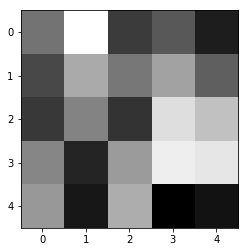

In [62]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### Filter an image to see the effect of a convolutional kernel
---

/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
/home/workspace/data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


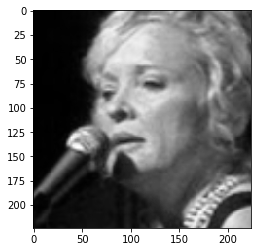

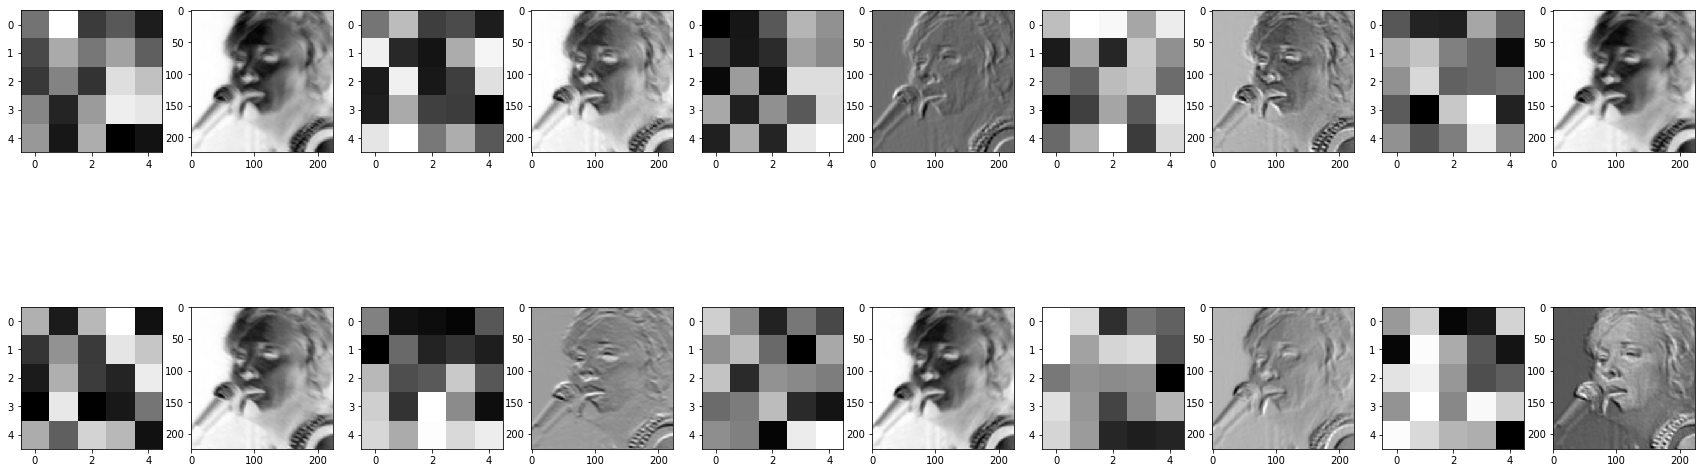

In [63]:
import cv2

##load in and display any image from the transformed test dataset
idx = 1
test_images, test_outputs, gt_pts = net_sample_output()
    
##Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image

# un-transform the image data
image = test_images[idx].data   # get the image from it's Variable wrapper
image = image.numpy()   # convert to numpy array from a Tensor
image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

img = np.squeeze(image)
plt.imshow(img, cmap='gray')

fig=plt.figure(figsize=(30, 10))
columns = 5*2
rows = 2
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c, cmap='gray')
plt.show()

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: The last fillter in the second blurs out the noise.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!